In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import integrate
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform


def mquiver(xs, ys, v, **kw):
 
    X,Y = np.meshgrid(xs, ys)
    V = [[v(x,y) for x in xs] for y in ys]
    VX = [[w[0] for w in q] for q in V]
    VY = [[w[1] for w in q] for q in V]
    plt.quiver(X, Y, VX, VY, **kw)


def dirfield(xs, ys, f, **kw):
  
    xs, ys = list(xs), list(ys) 
    mquiver(xs, ys, lambda x,y: (1,f(x,y)), scale=90, headwidth=0.0,
                    headlength=0.0,
                    headaxislength=0.0,pivot='middle',angles='xy',**kw)


def mplot(xs, f, **kw):

    plt.plot(xs, list(map(f,xs)), **kw)


def axes4x4(labels=("t","x"),xmin=-4, xmax=4, ymin=-4, ymax=4, fontsize=20):

    plt.axis([xmin,xmax, ymin, ymax])
    center_spines()
    xscale = (xmax - xmin) / 8.
    yscale = (ymax - ymin) / 8.
    plt.text(xmax - 0.2 * xscale, 0.2 * yscale, "$%s$" % labels[0],
             fontsize=fontsize, verticalalignment='bottom')
    plt.text(0.1 * xscale, ymax - 0.3 * yscale, "$%s$" % labels[1],
             fontsize=fontsize)


def draw_axes(xmin, xmax, ymin, ymax, labels=("x", "y")):
    plt.axis([xmin, xmax, ymin, ymax])
    center_spines()
    plt.text(xmax, 0, "$%s$" % labels[0],fontsize=20, verticalalignment='bottom', horizontalalignment='right')
    plt.text(0, ymax, "$%s$" % labels[1],fontsize=20, verticalalignment='top', horizontalalignment='right')


def normdirfield(xs,ys,f,**kw):
   
    length= kw.pop('length') if 'length' in kw else 1
    xlist = []
    ylist = []
    for x in xs:
        for y in ys:
            vy = f(x,y)
            prelen = np.sqrt(1+vy**2)
            deltax = 1/prelen*length
            deltay = vy/prelen*length
            xlist.extend([x-deltax/2,x+deltax/2,None])
            ylist.extend([(-deltax/2)*vy+y,(deltax/2)*vy+y,None])
    plt.plot(xlist,ylist,**kw)

def center_spines(ax=None, centerx=0, centery=0, grid=True,
                  minor_ticks=True, axes=('x', 'y')):
  
    if ax is None:
        ax = plt.gca()

    ax.spines['left'].set_position(('data', centerx))
    ax.spines['bottom'].set_position(('data', centery))
    ax.spines['right'].set_position(('data', centerx))
    ax.spines['top'].set_position(('data', centery))

    for side in ['left', 'bottom', 'right', 'top']:
        ax.spines[side].set_color('none')

    for axis, center in zip([ax.xaxis, ax.yaxis], [centerx, centery]):
        
        axis.set_ticks_position('both')
        if grid:
            axis.grid(True, 'major', ls='solid', lw=0.5, color='gray')

        if minor_ticks:
            axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        formatter = CenteredFormatter()
        formatter.center = center
        axis.set_major_formatter(formatter)

    xlabel, ylabel = map(str, [centerx, centery])
    if centerx != 0 or centery != 0:
        annotation = '(%s, %s)' % (xlabel, ylabel)
    else:
        annotation = xlabel
    ax.annotate(annotation, (centerx, centery),
            xytext=(-4, -4), textcoords='offset points',
            ha='right', va='top')

    if 'x' in axes:
        ax.annotate("", xytext=(0, 0), xy=(1, 0),
                    xycoords=ax.get_yaxis_transform(),
                    arrowprops=dict(arrowstyle='->'))
    if 'y' in axes:
        ax.annotate("", xytext=(0, 0), xy=(0, 1),
                    xycoords=ax.get_xaxis_transform(),
                    arrowprops=dict(arrowstyle='->'))

 
class CenteredFormatter(mpl.ticker.ScalarFormatter):
    """Acts exactly like the default Scalar Formatter, but yields an empty
    label for ticks at "center"."""
    center = 0
    def __call__(self, value, pos=None):
        if value == self.center:
            return ''
        else:
            return mpl.ticker.ScalarFormatter.__call__(self, value, pos)


def settle_axes(xmin, xmax, ymin, ymax,
             xlabel="x",
             ylabel="y",
             ax=None,
             axlabelshift=1, axlabelshift_h=None, axlabelshift_v=None):

    if ax is None:
        ax = plt.gca()
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)

    xwidth = xmax - xmin
    ywidth = ymax - ymin

    if xlabel:
        ax.set_xlabel(f'${xlabel}$', x=1)

    ticklab = next(iter(ax.xaxis.get_ticklabels()), None)
    if ticklab:
        trans = ticklab.get_transform()
        ax.xaxis.set_label_coords(xmax, 0, transform=trans)
    if ylabel:
        ax.set_ylabel(f'${ylabel}$', y=1, rotation=0)

    ticklab = next(iter(ax.yaxis.get_ticklabels()), None)
    if ticklab:
        trans = ticklab.get_transform()
        axlabelshift_h = axlabelshift if axlabelshift_h is None else axlabelshift_h
        axlabelshift_v = axlabelshift if axlabelshift_v is None else axlabelshift_v

        ax.yaxis.set_label_coords(xwidth * 0.04 * axlabelshift_h,
                                  ymax - ywidth * 0.05 * axlabelshift_v, transform=trans)


def eulersplot(f, xa, xb, ya, n = 500, toolarge = 1E10, **kw):
  
    h = (xb - xa) / float(n)
    x = [xa] 
    y = [ya]
    for i in range(1,n+1):
        newy = y[-1] + h * f(x[-1], y[-1])
        if abs(newy) > toolarge:
            break
        y.append(newy)
        x.append(x[-1] + h)
    plt.plot(x,y, **kw)


def normvectorfield(xs,ys,fs,**kw):

    length = kw.pop('length') if 'length' in kw else 1
    x, y = np.meshgrid(xs, ys)
    # calculate vector field
    vx,vy = fs(x,y)
    # plot vector field
    norm = length /np.sqrt(vx**2+vy**2)
    plt.quiver(x, y, vx * norm, vy * norm, angles='xy',**kw)


def vectorfield(xs,ys,fs,**kw):
   
    length = kw.pop('length') if 'length' in kw else 1
    x, y = np.meshgrid(xs, ys)
    # calculate vector field
    vx,vy=fs(x,y)
    # plot vecor field
    norm = length 
    plt.quiver(x, y, vx * norm, vy * norm, angles='xy',**kw)


def plottrajectories(fs, x0, t=np.linspace(1,400,10000), **kw):
   
    x0 = np.array(x0)
    X = integrate.odeint( fs, x0, t)
    plt.plot(X[:,0], X[:,1], **kw)


def phaseportrait(fs, inits, t=(-5, 5), n=100, firstint=None, arrow=True,
                  xmin=None, ymin=None, xmax=None, ymax=None, gridstep=200,
                  head_width = 0.13, 
                  head_length=0.3, arrow_size=1, singpoint_size=0, 
                  singcolor='steelblue', contourcolor='steelblue', **kw):
   
    try:
        tmin = t[0]
        tmax = t[1]
        assert tmin <= 0 and tmax >= 0 
    except TypeError:
        tmin = 0
        tmax = t
    head_width *= arrow_size
    head_length *= arrow_size

    points = []
    inits = np.array(inits)
    integrator = integrate.ode(lambda t, X: fs(X)).set_integrator('vode')
    if firstint is None:
        for x0 in inits:
            if tmin < 0:
                segments=[(tmin, tmin/n), (tmax, tmax/n)]
            else:
                segments=[(tmax, tmax/n)]
            
            for T, delta_t in segments:
                integrator.set_initial_value(x0)
                points.append(x0)
                sign = np.sign(delta_t)
                
                while (sign * integrator.t < sign * T):
                    point = integrator.integrate(integrator.t + delta_t)
                    if not integrator.successful():
                        break
                    if ((xmin is not None and point[0] < xmin) or
                        (xmax is not None and point[0] > xmax) or
                        (ymin is not None and point[1] < ymin) or
                        (ymax is not None and point[1] > ymax)):
                        point = [None, None]
                    points.append(point)
                points.append([None, None])
        points = np.array(points)
        plt.plot(points[:, 0], points[:, 1],**kw)
    else:
        assert None not in [xmin, xmax, ymin, ymax], \
                ("Please, specify xmin, xmax, ymin, ymax and gridstep"
                 "if you use first integral")
        X = np.linspace(xmin, xmax, gridstep)
        Y = np.linspace(xmin, xmax, gridstep)
        # Z = np.array([[firstint(np.array([x, y])) for x in X] for y in Y])
        try:
            Z = firstint(np.meshgrid(X, Y))
            # fast version for ufunc-compatible firstint
        except:
            print("Can't use vectorized first integral,"
                  " falling back to loops")
            Z = np.array([[firstint(np.array([x, y])) for x in X] for y in Y])
        levels = sorted({firstint(x0) for x0 in inits})
        plt.contour(X, Y, Z, levels=levels, colors=contourcolor)
        
    for x0 in inits:
        vector = np.array(fs(x0))
        if arrow:
            if scipy.linalg.norm(vector) > 1E-5:
                direction = vector / scipy.linalg.norm(vector) * 0.01
            else:
                direction = None
            if 'color' in kw:
                arrow_params = dict(fc=kw['color'],
                                    ec=kw['color'])
            else:
                arrow_params = {}
            if direction is not None:
                plt.arrow(x0[0] - direction[0],
                          x0[1] - direction[1],
                          direction[0],
                          direction[1], 
                          head_width=head_width, 
                          head_length=head_length, 
                          lw=0.0, **arrow_params)
            else:
                plt.plot([x0[0]], [x0[1]], 
                         marker='o', mew=2 * singpoint_size, 
                         lw=0, markersize=5 * singpoint_size,
                         markerfacecolor='white', markeredgecolor=singcolor)


def mcontour(xs, ys, fs, levels=None, **kw):
   
    x,y=np.meshgrid(xs,ys)
    z=fs(x,y)
    if levels!=None:
        plt.contour(x,y,z,sorted(set(levels)),**kw)
    else:
        plt.contour(x,y,z,**kw)


def get_default(from_, **kwargs):
    return {k:from_.get(k, v) for k, v in kwargs.items()}


def onedim_phasecurves(left, right, singpoints, directions, 
                       orientation='vertical', shift=0, 
                       delta=0.05, **kwargs):
    
    assert len(directions) == len(singpoints) + 1
    assert orientation in ['vertical', 'horizontal']
    n = len(singpoints)
    defaultcolor = 'Teal'
    plot_params = get_default(kwargs, color=defaultcolor, marker='o', 
                       fillstyle='none', mew=5, lw=0, markersize=2)
    quiver_params = dict(angles='xy', 
                         scale_units='xy', scale=1, units='inches')
    quiver_params.update(get_default(kwargs, width=0.03, 
                                      color=defaultcolor))

    baseline = np.zeros(n) + shift
    if orientation == 'vertical':
        plt.plot(baseline, singpoints, **plot_params)
    else:
        plt.plot(singpoints, baseline, **plot_params)

    if singpoints:
        if singpoints[0] == left:
            singpoints.pop(0)
            directions.pop(0)
            n -= 1
    if singpoints:
        if singpoints[-1] == right:
            singpoints.pop()
            directions.pop()
            n -= 1

    xs = np.zeros(n + 1) + shift
    ys = []
    us = np.zeros(n + 1)
    vs = []

    endpoints = [left] + list(singpoints) + [right]
    for i, direction in enumerate(directions):
        if direction > 0:
            beginning = endpoints[i]
            ending = endpoints[i+1]
        elif direction < 0:
            beginning = endpoints[i+1]
            ending = endpoints[i]
        else:
            raise Exception("direction should be >0 or <0")
        ys.append(beginning + np.sign(direction) * delta)
        vs.append(ending - beginning - np.sign(direction)*2*delta)
    if orientation == 'vertical':
        plt.quiver(xs, ys, us, vs, **quiver_params, **kwargs)
    else:
        plt.quiver(ys, xs, vs, us, **quiver_params, **kwargs)

class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2),
                                    self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


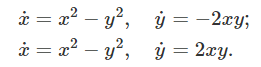

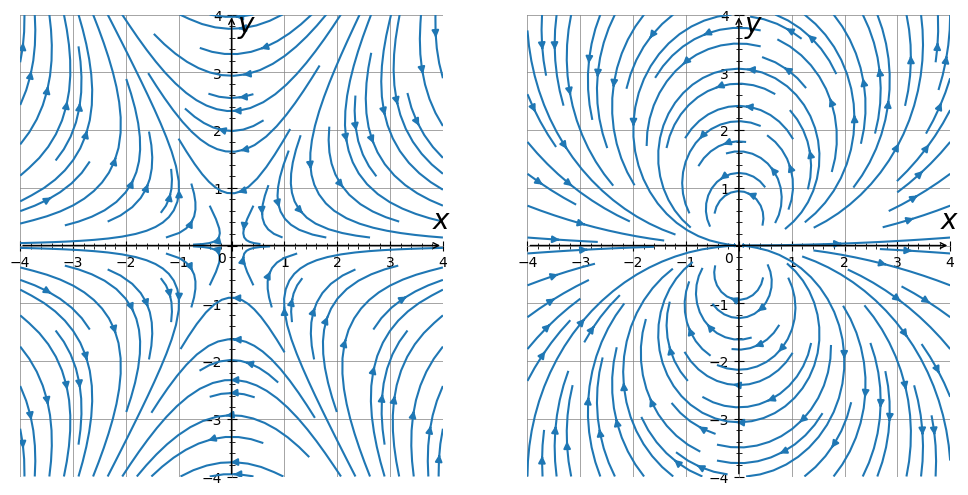

In [60]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, X**2 - Y**2, -2*X*Y)
plt.subplot(122)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, X**2 - Y**2, 2*X*Y)

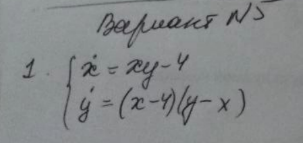

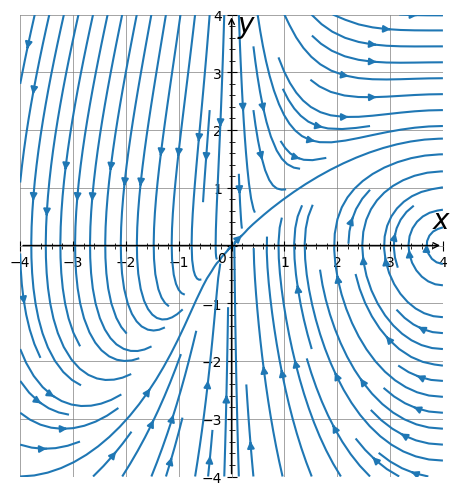

In [61]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, X*Y, (X-4)*(Y-X))


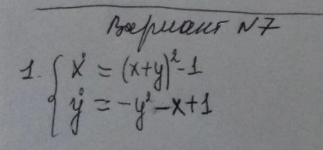

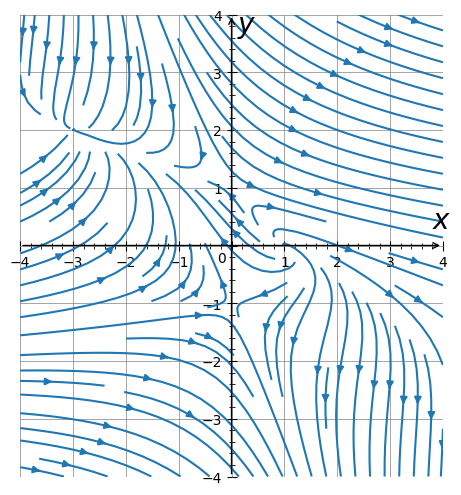

In [62]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, (X+Y)**2-1, -Y**2-X+1)


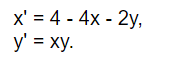

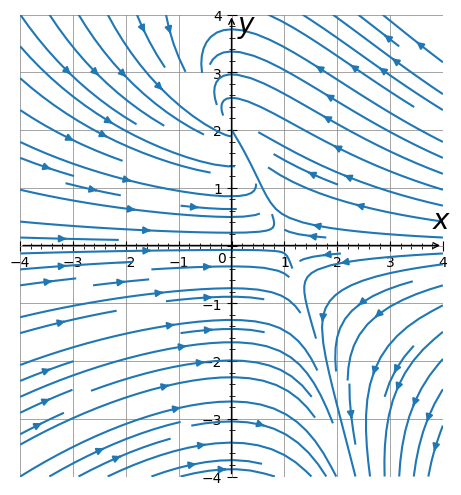

In [63]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, 4-X*4-2*Y, X*Y)


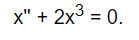

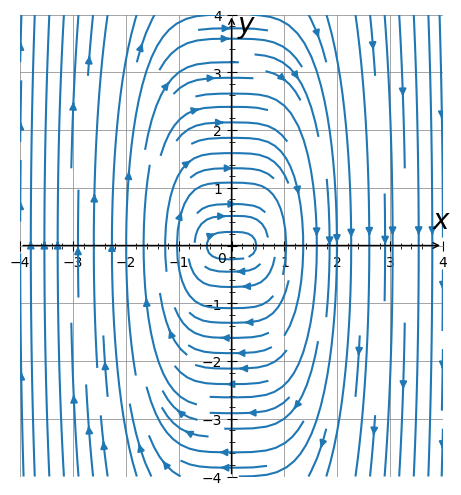

In [64]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, Y, -2*X**3)


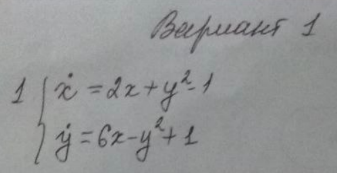

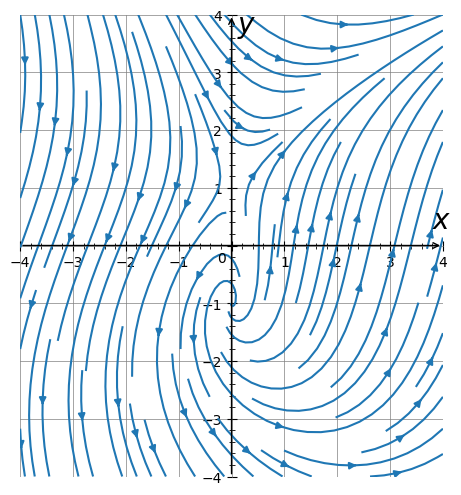

In [65]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, 2*X+Y**2-1, 6*X-Y**2+1)


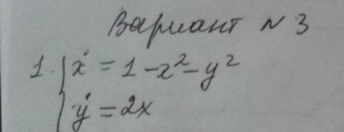

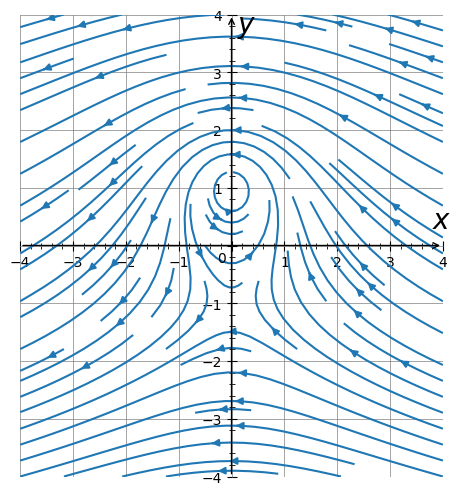

In [66]:
plt.figure(figsize=(12, 6))

x = np.linspace(-4, 4)
y = np.linspace(-4, 4)
X, Y = np.meshgrid(x, y)
plt.subplot(121)
axes4x4(labels=('x', 'y'))
plt.streamplot(x, y, 1-X**2-Y**2, 2*X)
